# Laboratorium 3 - Czy sieci neuronowe śnią o ciastach marchewkowych?

In [1]:
import os
from datetime import datetime

import IPython.display as d

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import matplotlib.pyplot as plt


def normalize_image(image: torch.Tensor) -> torch.Tensor:
    return (image - image.min()) / (image.max() - image.min())


def display(
    *images: torch.Tensor,
    resize_scale: tuple[float, float] | None = None
) -> None:
    if (len(images) == 0):
        return

    pil_images: list[Image.Image] \
        = [F.to_pil_image(image) for image in images]

    if resize_scale is not None:
        sw, sh = resize_scale
        for i, image in enumerate(pil_images):
            w, h = image.size
            size: tuple[int, int] = int(sw * w), int(sh * h)
            pil_images[i] = image.resize(size, Image.Resampling.NEAREST)

    d.display(*pil_images)


def show_samples(images: torch.Tensor) -> None:
    sample_count: int = images.size(dim=0)

    _, axes = plt.subplots(1, sample_count, figsize=(15, 5))
    for i in range(sample_count):
        image = images[i].permute(1, 2, 0).numpy()
        axes[i].imshow(image)
        axes[i].axis("off")

    plt.show()


GENERATOR_INPUT_SIZE = 64
BATCH_SIZE = 32

## To chyba nie jest oryginalny Breitling, prawda?

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(64 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

## Skoro nie widać różnicy...?

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model: nn.Sequential = nn.Sequential(
            nn.Linear(GENERATOR_INPUT_SIZE, GENERATOR_INPUT_SIZE * 4 * 4),
            nn.Unflatten(dim=1, unflattened_size=(64, 4, 4)),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(256, 3, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

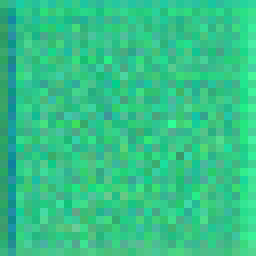

In [4]:
device: torch.device = torch.device(
    "mps" if torch.backends.mps.is_built()
        else "cuda" if torch.backends.cuda.is_built()
            else "cpu"
)

generator: Generator = Generator()
generator.to(device)

noise = torch.randn(1, GENERATOR_INPUT_SIZE).to(device)
generator.eval()
with torch.no_grad():
    generated_image: torch.Tensor = generator(noise).squeeze()
generated_image = (generated_image + 1.0) / 2.0


display(normalize_image(generated_image), resize_scale=(8.0, 8.0))

## I zebrano jeszcze dwanaście koszy ułomków

In [5]:
class CarrotCakeDataset(Dataset):
    def __init__(
        self,
        image_dir: str,
        transform: transforms.Transform | None = None
    ):
        self.image_dir: str = image_dir
        self.image_files: list[str] = os.listdir(image_dir)
        self.transform: transforms.Transform | None = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx: int) -> torch.Tensor:
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image

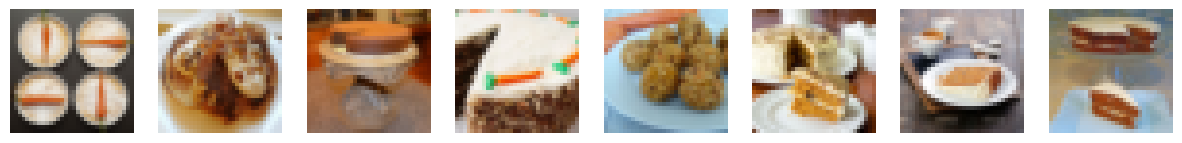

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset_path = "./dataset/crawled-cakes"

dataset = CarrotCakeDataset(dataset_path, transform=transform)
data_loader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

show_samples(next(iter(data_loader))[:8] * 0.5 + 0.5)

## Work it harder, make it better

In [7]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [8]:
simple_model = SimpleModel()

input_data = torch.randn((9, 3), requires_grad=True)
output = simple_model(input_data)
fake_loss_d = output.mean() - 42

simple_model.fc1.weight.retain_grad()
fake_loss_d.backward(retain_graph=True)

optimizer = optim.SGD([simple_model.fc1.weight, simple_model.fc1.bias], lr=0.01)

for i in range(5):
    optimizer.zero_grad()
    output = simple_model(input_data)
    fake_loss_d = output.mean() - 42

    fake_loss_d.backward(retain_graph=True)
    optimizer.step()

    print(f"Epoch {i + 1}, loss: {fake_loss_d.item()}")

Epoch 1, loss: -42.552528381347656
Epoch 2, loss: -42.55421447753906
Epoch 3, loss: -42.555904388427734
Epoch 4, loss: -42.55759048461914
Epoch 5, loss: -42.55928039550781


In [9]:
def train_progress(
    epoch: int,
    epoch_count: int,
    noise_vectors: torch.Tensor,
    mean_loss_d: float,
    mean_loss_g: float,
    discriminator: Discriminator,
    generator: Generator,
    optimizer_d: optim.Optimizer,
    optimizer_g: optim.Optimizer
) -> None:
    def log(epoch: int, message: str) -> None:
        pretty_date: str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"{pretty_date} — Epoch [{epoch + 1}/{epoch_count}] — {message}")

    log(epoch, f"Discriminator Loss: {mean_loss_d:.4f}")
    log(epoch, f"Generator Loss: {mean_loss_g:.4f}")

    generator.eval()
    generated_images: torch.Tensor = generator(noise_vectors)

    show_samples(normalize_image(generated_images.detach().cpu()[:8]))
    save_image(
        generated_images,
        os.path.join("checkpoints/image", f"epoch_{epoch + 1}.png"),
        nrow=5,
        normalize=True
    )

    torch.save({
        "epoch": epoch,
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "optimizer_d_state_dict": optimizer_d.state_dict(),
        "optimizer_g_state_dict": optimizer_g.state_dict(),
        "noise_vectors": noise_vectors,
    }, os.path.join("checkpoints/torch", f"epoch_{epoch + 1}.pt"))

def train(
    discriminator: Discriminator,
    generator: Generator,
    data_loader: DataLoader,
    device: torch.device | None = None,
    epoch_count: int = 10,
    save_every_n_epochs: int = 50
) -> None:
    if device is None:
        device: torch.device = torch.device(
            "mps" if torch.backends.mps.is_built()
                else "cuda" if torch.backends.cuda.is_built()
                    else "cpu"
        )

    discriminator.to(device)
    generator.to(device)

    criterion: nn.BCELoss = nn.BCELoss()
    optimizer_d = optim.Adam(
        discriminator.parameters(), lr=1e-5, betas=(0.7, 0.999), weight_decay=1e-2
    )
    optimizer_g = optim.Adam(generator.parameters(), lr=1e-5, betas=(0.7, 0.999))

    base_noise_vectors: torch.Tensor = torch.randn(25, GENERATOR_INPUT_SIZE) \
        .to(device)

    def train_discriminator(
        real_images: torch.Tensor,
        fake_images: torch.Tensor,
        real_labels: torch.Tensor,
        fake_labels: torch.Tensor
    ) -> float:
        real_d_outputs = discriminator(real_images)
        real_loss_d = criterion(real_d_outputs, real_labels)

        fake_d_outputs = discriminator(fake_images.detach())
        fake_loss_d = criterion(fake_d_outputs, fake_labels)

        loss_d = (real_loss_d + fake_loss_d) / 2

        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        return loss_d.item()

    def train_generator(
        fake_images: torch.Tensor,
        real_labels: torch.Tensor
    ) -> float:
        g_outputs = discriminator(fake_images)
        loss_g = criterion(g_outputs, real_labels)

        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        return loss_g.item()

    for epoch in range(epoch_count):
        generator.train()
        discriminator.train()

        cumulative_loss_d: float = 0.0
        cumulative_loss_g: float = 0.0

        for real_images in data_loader:
            real_images = real_images.to(device)
            real_labels: torch.Tensor = torch.normal(
                1.0, 0.05, (real_images.size(dim=0), 1)
            ).to(device)

            noise = torch.randn(real_images.size(dim=0), GENERATOR_INPUT_SIZE) \
                .to(device)
            fake_images = generator(noise)
            fake_labels = torch.normal(
                0.0, 0.05, (real_images.size(dim=0), 1)
            ) \
                .to(device)

            cumulative_loss_d += train_discriminator(
                real_images, fake_images, real_labels, fake_labels
            )
            cumulative_loss_g += train_generator(fake_images, real_labels)

        mean_loss_d: float = cumulative_loss_d / len(data_loader)
        mean_loss_g: float = cumulative_loss_g / len(data_loader)

        if (epoch + 1) % save_every_n_epochs == 0 or epoch == 0:
            train_progress(
                epoch,
                epoch_count,
                base_noise_vectors,
                mean_loss_d,
                mean_loss_g,
                discriminator,
                generator,
                optimizer_d,
                optimizer_g
            )

2024-11-10 17:34:58 — Epoch [1/3000] — Discriminator Loss: 0.7797
2024-11-10 17:34:58 — Epoch [1/3000] — Generator Loss: 0.6414


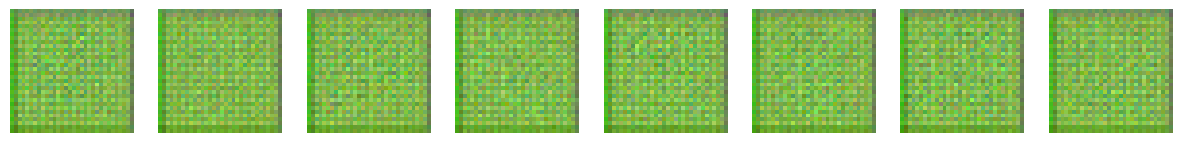

2024-11-10 17:38:22 — Epoch [50/3000] — Discriminator Loss: 0.6613
2024-11-10 17:38:22 — Epoch [50/3000] — Generator Loss: 0.7914


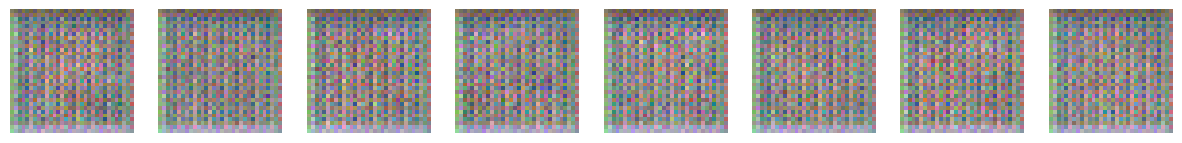

2024-11-10 17:41:46 — Epoch [100/3000] — Discriminator Loss: 0.5816
2024-11-10 17:41:46 — Epoch [100/3000] — Generator Loss: 0.8840


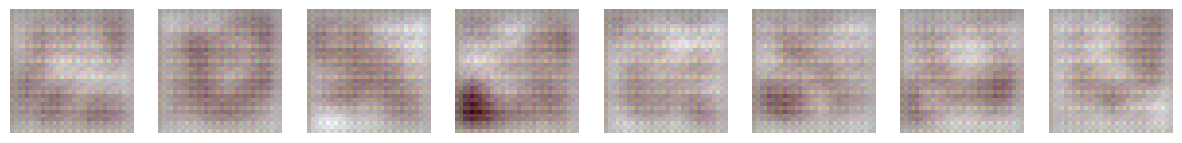

2024-11-10 17:44:59 — Epoch [150/3000] — Discriminator Loss: 0.6557
2024-11-10 17:44:59 — Epoch [150/3000] — Generator Loss: 0.7438


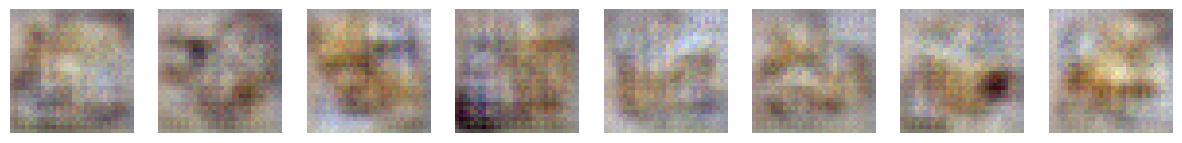

2024-11-10 17:47:57 — Epoch [200/3000] — Discriminator Loss: 0.6470
2024-11-10 17:47:57 — Epoch [200/3000] — Generator Loss: 0.7548


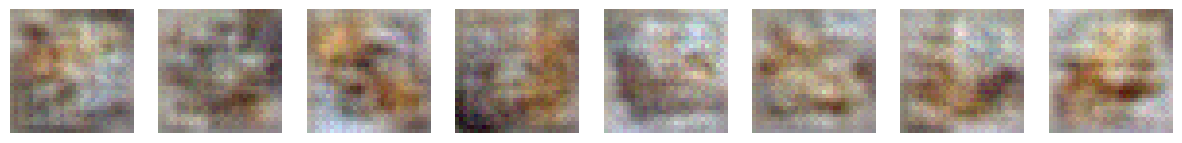

2024-11-10 17:50:47 — Epoch [250/3000] — Discriminator Loss: 0.6407
2024-11-10 17:50:47 — Epoch [250/3000] — Generator Loss: 0.7729


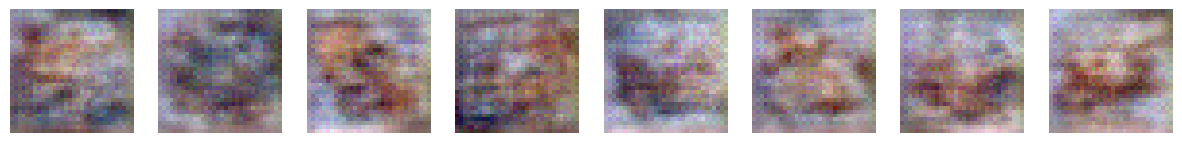

2024-11-10 17:53:44 — Epoch [300/3000] — Discriminator Loss: 0.6117
2024-11-10 17:53:44 — Epoch [300/3000] — Generator Loss: 0.8184


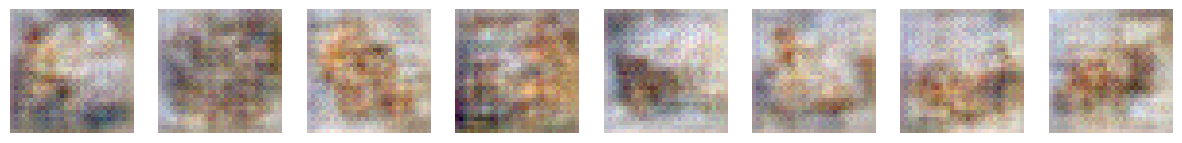

2024-11-10 17:56:49 — Epoch [350/3000] — Discriminator Loss: 0.5965
2024-11-10 17:56:49 — Epoch [350/3000] — Generator Loss: 0.8447


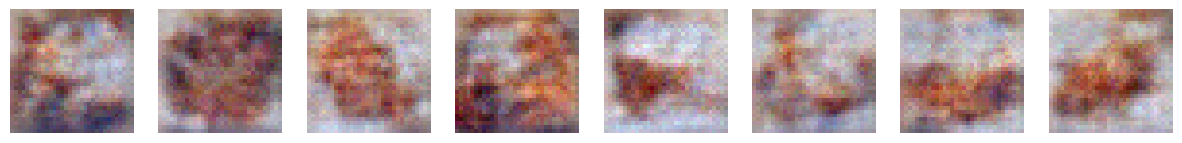

2024-11-10 18:00:13 — Epoch [400/3000] — Discriminator Loss: 0.6046
2024-11-10 18:00:13 — Epoch [400/3000] — Generator Loss: 0.8215


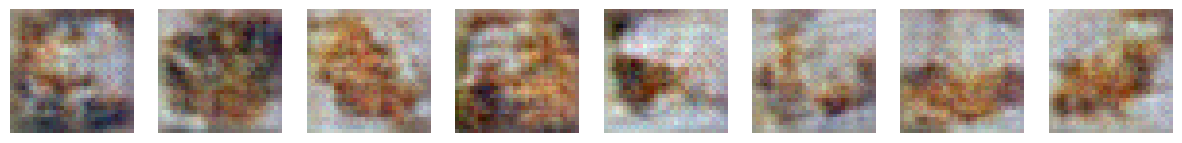

2024-11-10 18:03:22 — Epoch [450/3000] — Discriminator Loss: 0.6031
2024-11-10 18:03:22 — Epoch [450/3000] — Generator Loss: 0.8410


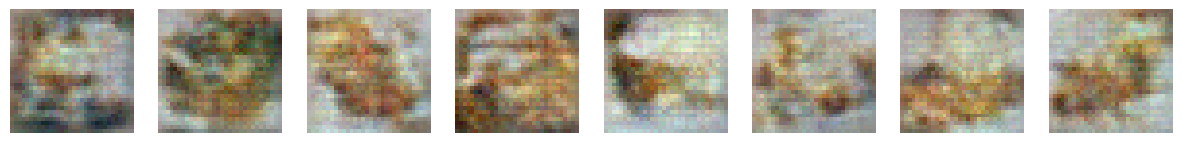

2024-11-10 18:06:26 — Epoch [500/3000] — Discriminator Loss: 0.5837
2024-11-10 18:06:26 — Epoch [500/3000] — Generator Loss: 0.8618


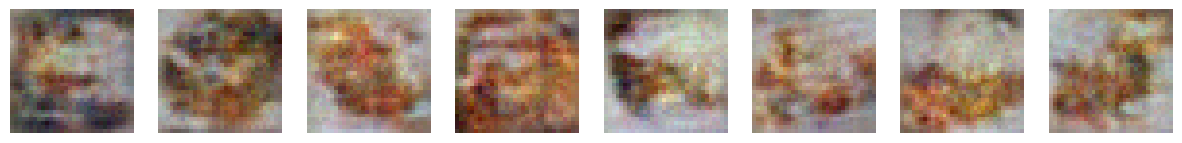

2024-11-10 18:09:20 — Epoch [550/3000] — Discriminator Loss: 0.5683
2024-11-10 18:09:20 — Epoch [550/3000] — Generator Loss: 0.8759


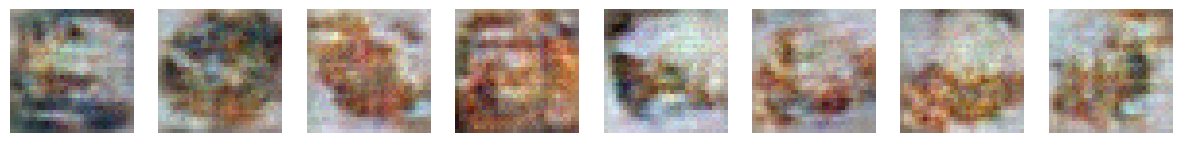

2024-11-10 18:12:14 — Epoch [600/3000] — Discriminator Loss: 0.5482
2024-11-10 18:12:14 — Epoch [600/3000] — Generator Loss: 0.9104


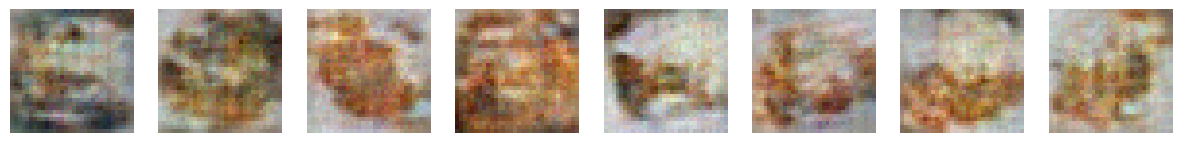

2024-11-10 18:15:06 — Epoch [650/3000] — Discriminator Loss: 0.5236
2024-11-10 18:15:06 — Epoch [650/3000] — Generator Loss: 0.9495


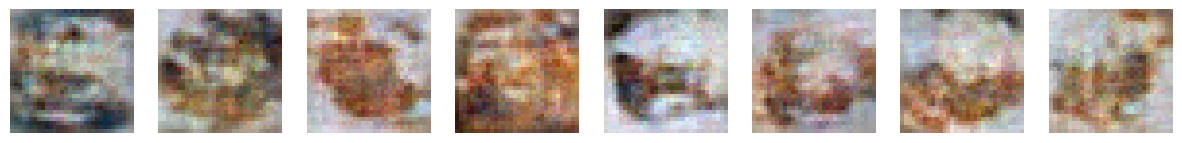

2024-11-10 18:18:03 — Epoch [700/3000] — Discriminator Loss: 0.5040
2024-11-10 18:18:03 — Epoch [700/3000] — Generator Loss: 0.9996


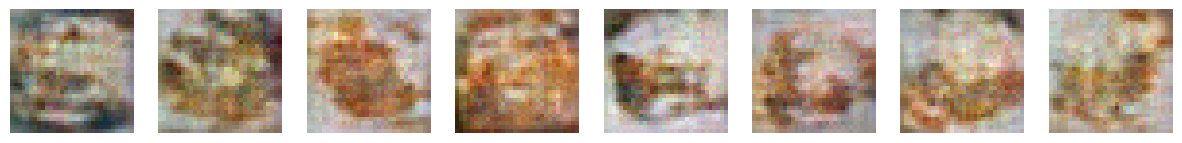

2024-11-10 18:20:58 — Epoch [750/3000] — Discriminator Loss: 0.4816
2024-11-10 18:20:58 — Epoch [750/3000] — Generator Loss: 1.0186


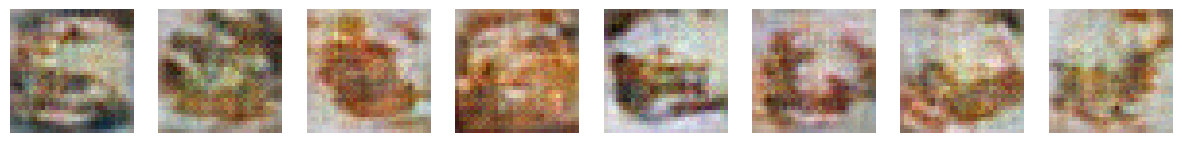

2024-11-10 18:23:55 — Epoch [800/3000] — Discriminator Loss: 0.4743
2024-11-10 18:23:55 — Epoch [800/3000] — Generator Loss: 1.0725


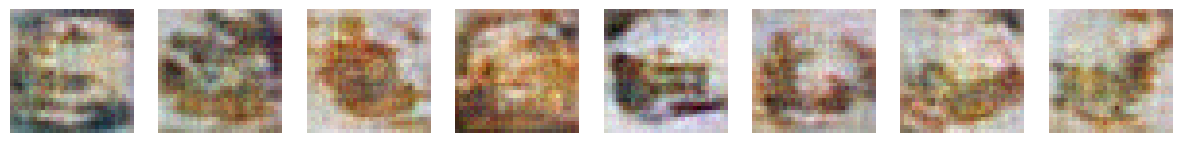

2024-11-10 18:26:55 — Epoch [850/3000] — Discriminator Loss: 0.4579
2024-11-10 18:26:55 — Epoch [850/3000] — Generator Loss: 1.0974


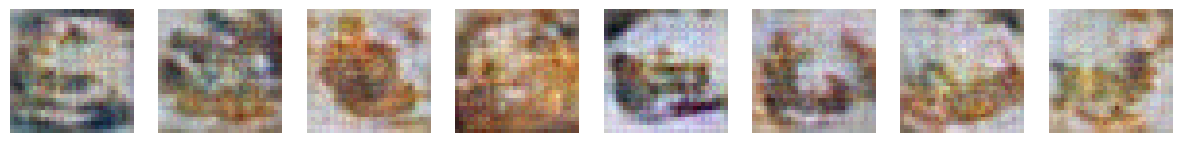

2024-11-10 18:29:54 — Epoch [900/3000] — Discriminator Loss: 0.4267
2024-11-10 18:29:54 — Epoch [900/3000] — Generator Loss: 1.1722


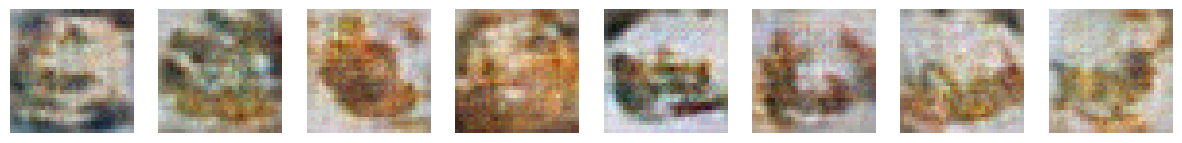

2024-11-10 18:33:01 — Epoch [950/3000] — Discriminator Loss: 0.4159
2024-11-10 18:33:01 — Epoch [950/3000] — Generator Loss: 1.2090


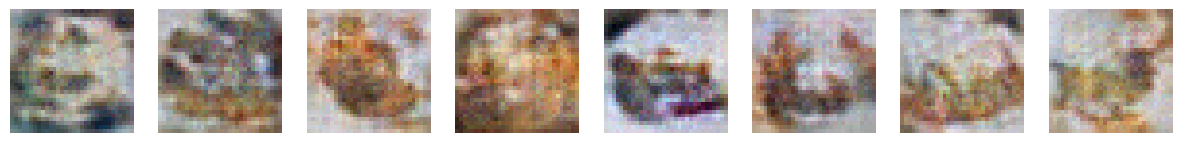

2024-11-10 18:36:28 — Epoch [1000/3000] — Discriminator Loss: 0.3990
2024-11-10 18:36:28 — Epoch [1000/3000] — Generator Loss: 1.2484


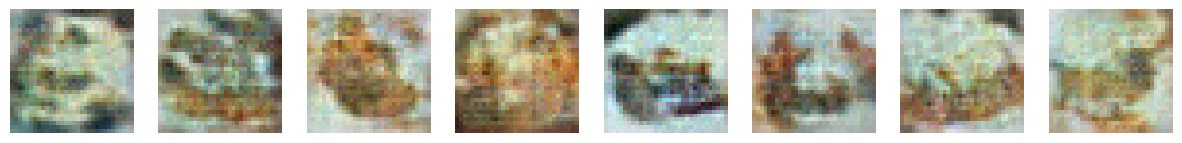

2024-11-10 18:39:46 — Epoch [1050/3000] — Discriminator Loss: 0.3872
2024-11-10 18:39:46 — Epoch [1050/3000] — Generator Loss: 1.2625


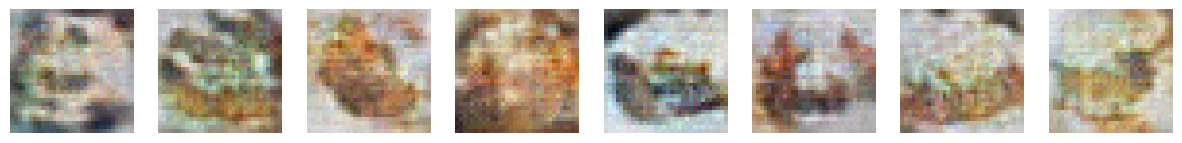

2024-11-10 18:43:12 — Epoch [1100/3000] — Discriminator Loss: 0.3706
2024-11-10 18:43:13 — Epoch [1100/3000] — Generator Loss: 1.3049


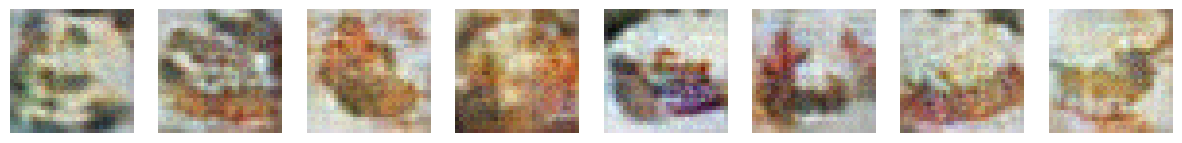

2024-11-10 18:46:38 — Epoch [1150/3000] — Discriminator Loss: 0.3611
2024-11-10 18:46:38 — Epoch [1150/3000] — Generator Loss: 1.3491


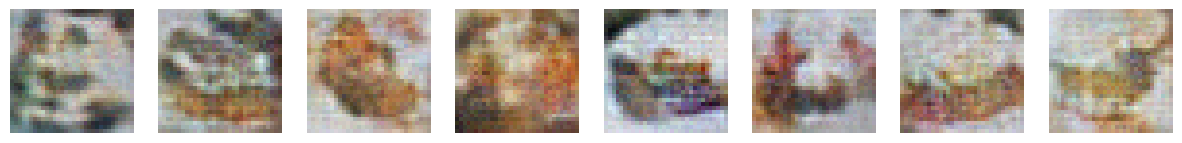

2024-11-10 18:49:49 — Epoch [1200/3000] — Discriminator Loss: 0.3285
2024-11-10 18:49:49 — Epoch [1200/3000] — Generator Loss: 1.4279


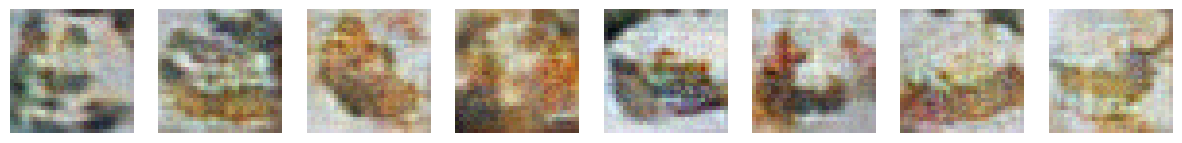

2024-11-10 18:53:09 — Epoch [1250/3000] — Discriminator Loss: 0.3229
2024-11-10 18:53:09 — Epoch [1250/3000] — Generator Loss: 1.4598


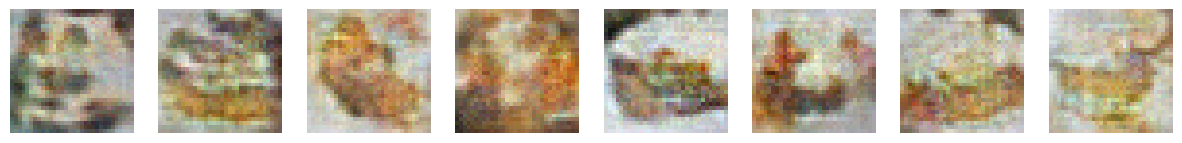

2024-11-10 18:56:35 — Epoch [1300/3000] — Discriminator Loss: 0.3014
2024-11-10 18:56:35 — Epoch [1300/3000] — Generator Loss: 1.5247


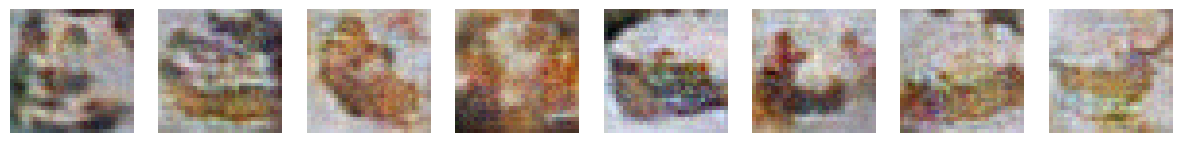

2024-11-10 18:59:50 — Epoch [1350/3000] — Discriminator Loss: 0.3002
2024-11-10 18:59:50 — Epoch [1350/3000] — Generator Loss: 1.5507


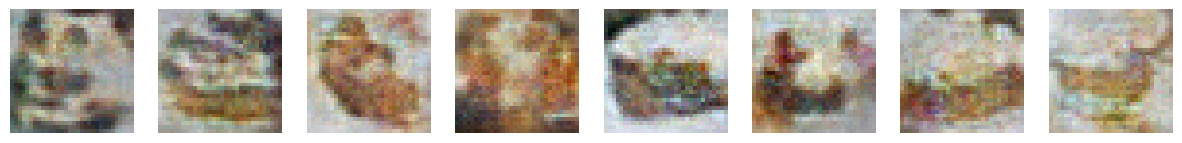

2024-11-10 19:02:58 — Epoch [1400/3000] — Discriminator Loss: 0.2892
2024-11-10 19:02:58 — Epoch [1400/3000] — Generator Loss: 1.5811


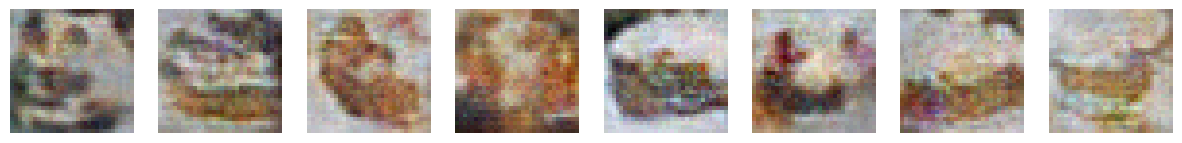

2024-11-10 19:06:09 — Epoch [1450/3000] — Discriminator Loss: 0.2809
2024-11-10 19:06:09 — Epoch [1450/3000] — Generator Loss: 1.6451


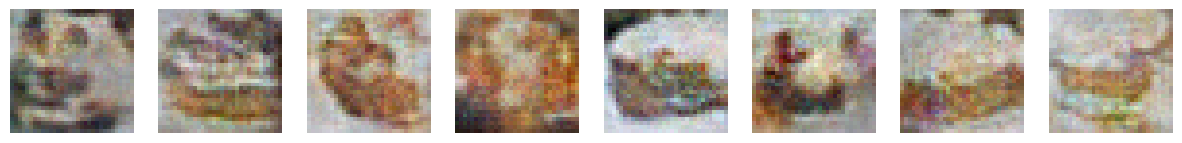

2024-11-10 19:09:19 — Epoch [1500/3000] — Discriminator Loss: 0.2662
2024-11-10 19:09:19 — Epoch [1500/3000] — Generator Loss: 1.7126


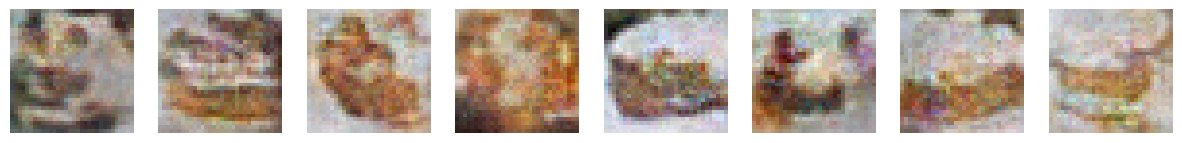

2024-11-10 19:12:33 — Epoch [1550/3000] — Discriminator Loss: 0.2604
2024-11-10 19:12:33 — Epoch [1550/3000] — Generator Loss: 1.7507


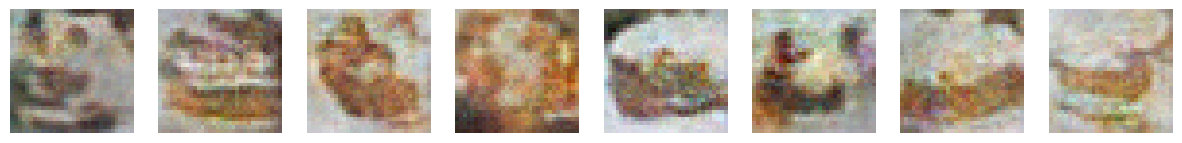

2024-11-10 19:15:46 — Epoch [1600/3000] — Discriminator Loss: 0.2504
2024-11-10 19:15:46 — Epoch [1600/3000] — Generator Loss: 1.7966


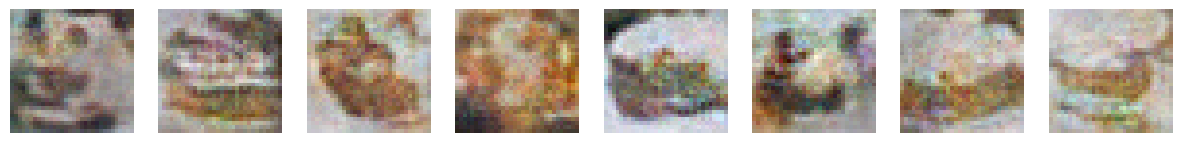

2024-11-10 19:18:58 — Epoch [1650/3000] — Discriminator Loss: 0.2317
2024-11-10 19:18:58 — Epoch [1650/3000] — Generator Loss: 1.8734


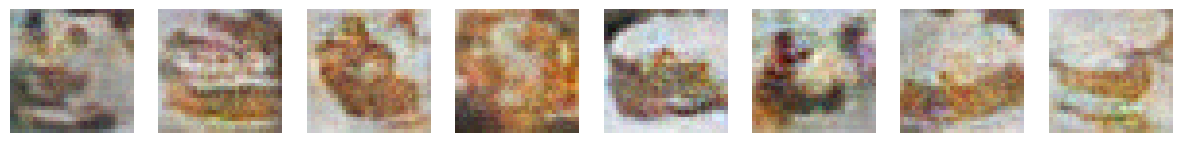

2024-11-10 19:22:08 — Epoch [1700/3000] — Discriminator Loss: 0.2273
2024-11-10 19:22:08 — Epoch [1700/3000] — Generator Loss: 1.8889


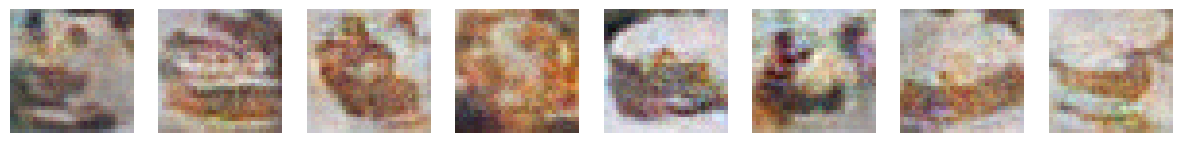

2024-11-10 19:25:25 — Epoch [1750/3000] — Discriminator Loss: 0.2176
2024-11-10 19:25:25 — Epoch [1750/3000] — Generator Loss: 1.9493


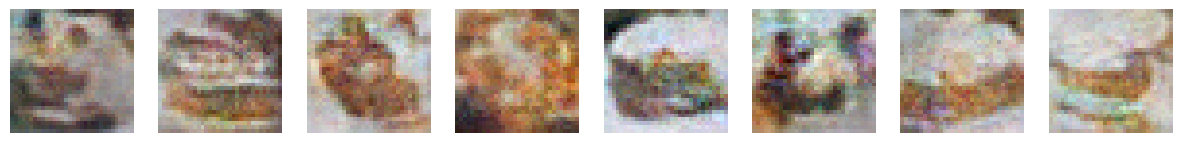

2024-11-10 19:28:36 — Epoch [1800/3000] — Discriminator Loss: 0.2070
2024-11-10 19:28:36 — Epoch [1800/3000] — Generator Loss: 1.9917


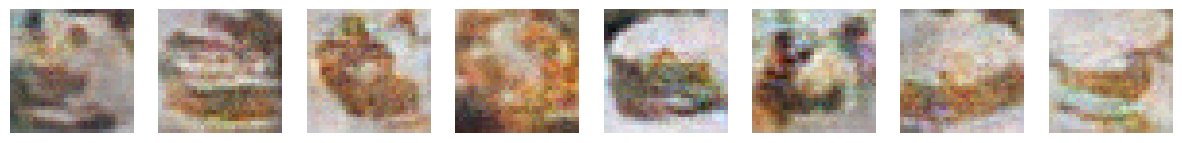

2024-11-10 19:31:49 — Epoch [1850/3000] — Discriminator Loss: 0.2026
2024-11-10 19:31:49 — Epoch [1850/3000] — Generator Loss: 2.0563


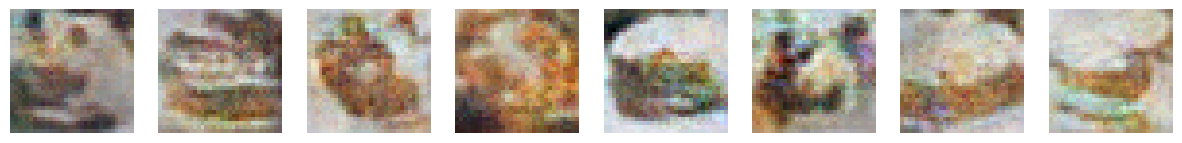

2024-11-10 19:35:06 — Epoch [1900/3000] — Discriminator Loss: 0.1912
2024-11-10 19:35:06 — Epoch [1900/3000] — Generator Loss: 2.0413


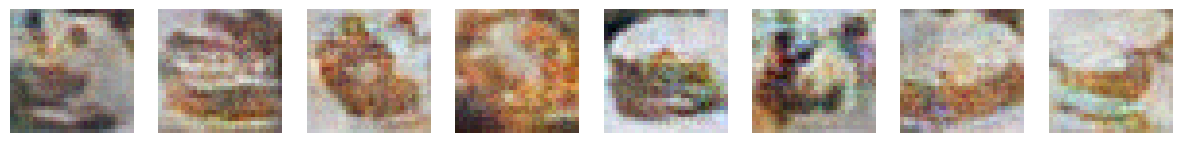

2024-11-10 19:38:27 — Epoch [1950/3000] — Discriminator Loss: 0.1822
2024-11-10 19:38:27 — Epoch [1950/3000] — Generator Loss: 2.0860


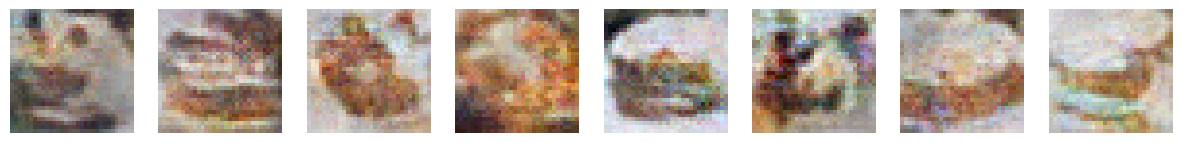

2024-11-10 19:41:57 — Epoch [2000/3000] — Discriminator Loss: 0.1799
2024-11-10 19:41:57 — Epoch [2000/3000] — Generator Loss: 2.2183


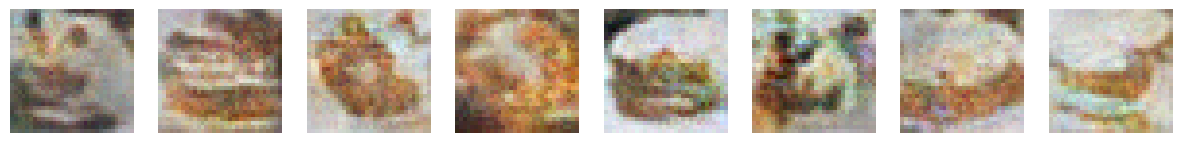

2024-11-10 19:45:19 — Epoch [2050/3000] — Discriminator Loss: 0.1725
2024-11-10 19:45:19 — Epoch [2050/3000] — Generator Loss: 2.2288


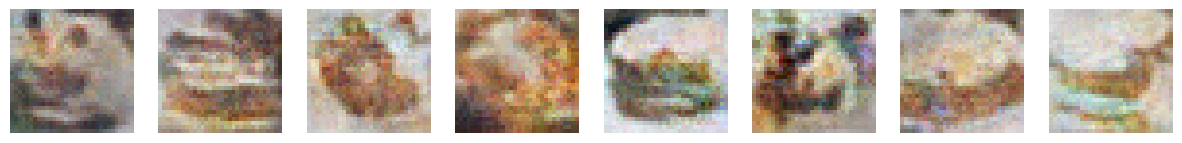

2024-11-10 19:48:47 — Epoch [2100/3000] — Discriminator Loss: 0.1588
2024-11-10 19:48:47 — Epoch [2100/3000] — Generator Loss: 2.2894


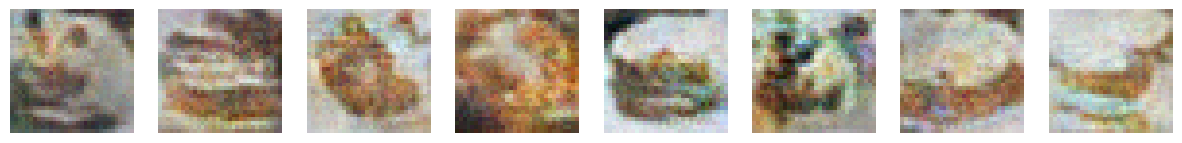

2024-11-10 19:52:12 — Epoch [2150/3000] — Discriminator Loss: 0.1576
2024-11-10 19:52:12 — Epoch [2150/3000] — Generator Loss: 2.3230


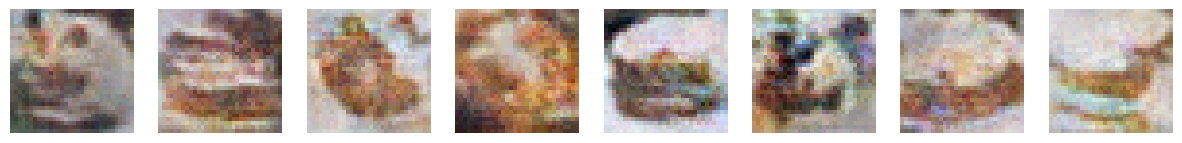

2024-11-10 19:55:24 — Epoch [2200/3000] — Discriminator Loss: 0.1509
2024-11-10 19:55:24 — Epoch [2200/3000] — Generator Loss: 2.3175


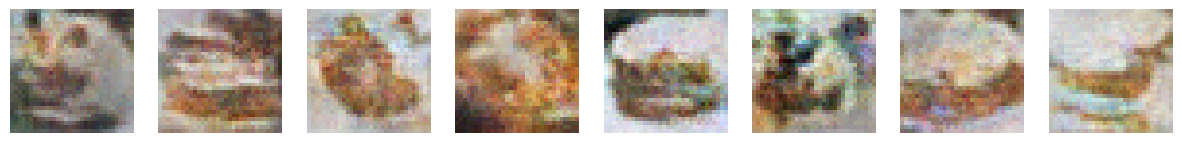

2024-11-10 19:58:35 — Epoch [2250/3000] — Discriminator Loss: 0.1537
2024-11-10 19:58:35 — Epoch [2250/3000] — Generator Loss: 2.3714


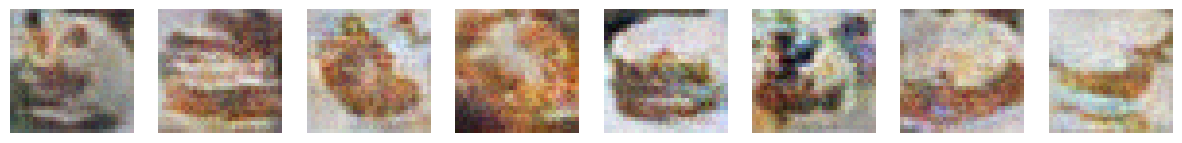

2024-11-10 20:01:49 — Epoch [2300/3000] — Discriminator Loss: 0.1425
2024-11-10 20:01:49 — Epoch [2300/3000] — Generator Loss: 2.4699


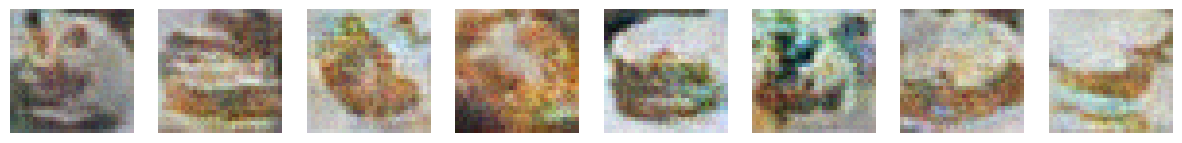

2024-11-10 20:04:57 — Epoch [2350/3000] — Discriminator Loss: 0.1424
2024-11-10 20:04:57 — Epoch [2350/3000] — Generator Loss: 2.4379


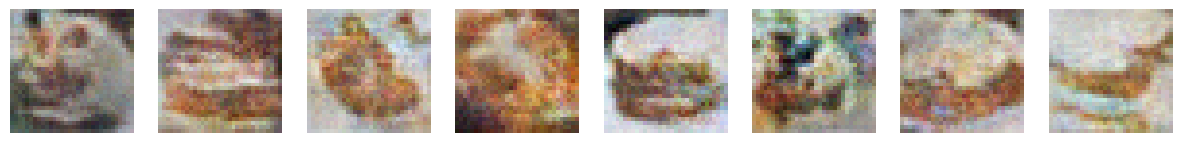

2024-11-10 20:08:31 — Epoch [2400/3000] — Discriminator Loss: 0.1249
2024-11-10 20:08:31 — Epoch [2400/3000] — Generator Loss: 2.5072


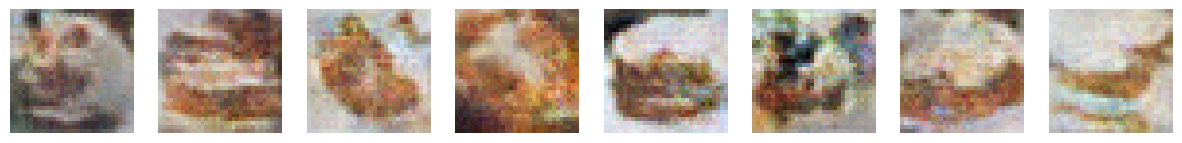

2024-11-10 20:11:43 — Epoch [2450/3000] — Discriminator Loss: 0.1431
2024-11-10 20:11:43 — Epoch [2450/3000] — Generator Loss: 2.5307


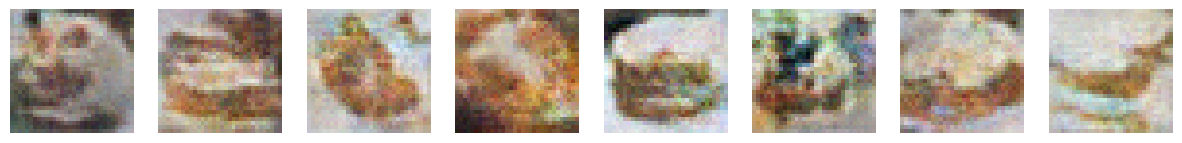

2024-11-10 20:14:44 — Epoch [2500/3000] — Discriminator Loss: 0.1377
2024-11-10 20:14:44 — Epoch [2500/3000] — Generator Loss: 2.5397


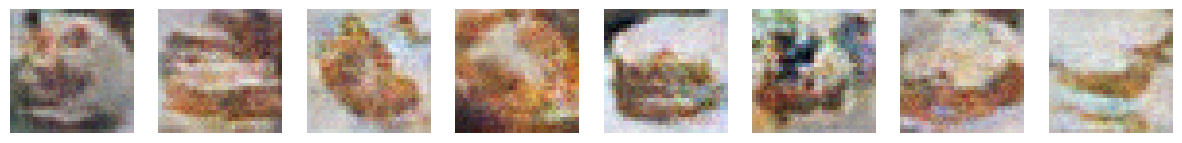

2024-11-10 20:17:47 — Epoch [2550/3000] — Discriminator Loss: 0.1197
2024-11-10 20:17:47 — Epoch [2550/3000] — Generator Loss: 2.6010


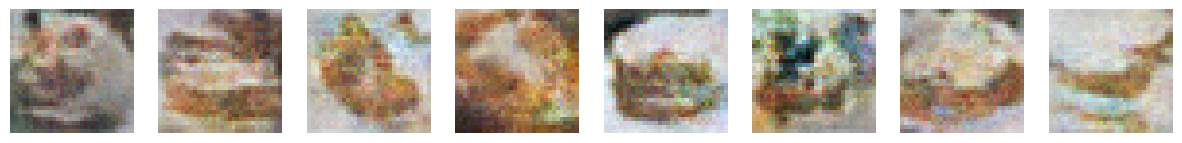

2024-11-10 20:20:50 — Epoch [2600/3000] — Discriminator Loss: 0.1227
2024-11-10 20:20:50 — Epoch [2600/3000] — Generator Loss: 2.6364


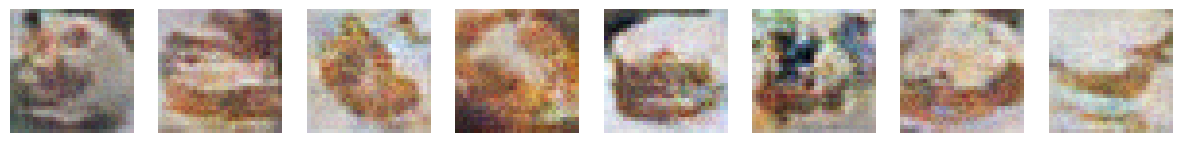

2024-11-10 20:23:53 — Epoch [2650/3000] — Discriminator Loss: 0.1227
2024-11-10 20:23:53 — Epoch [2650/3000] — Generator Loss: 2.6884


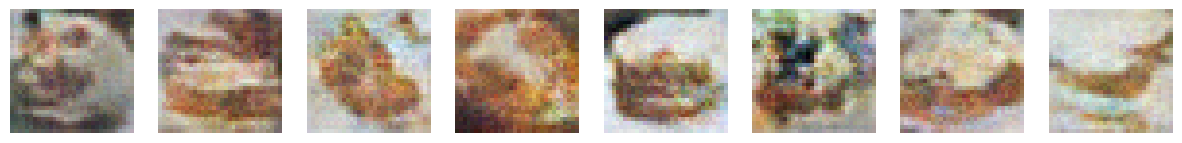

2024-11-10 20:27:03 — Epoch [2700/3000] — Discriminator Loss: 0.1186
2024-11-10 20:27:03 — Epoch [2700/3000] — Generator Loss: 2.6612


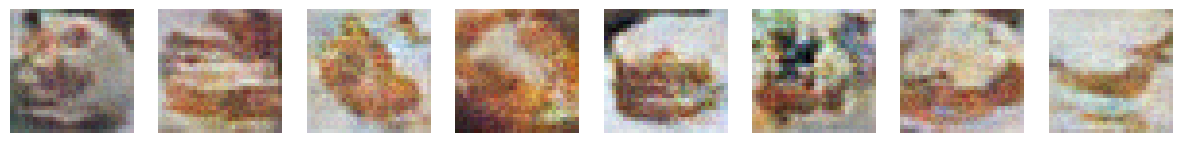

2024-11-10 20:30:07 — Epoch [2750/3000] — Discriminator Loss: 0.1118
2024-11-10 20:30:07 — Epoch [2750/3000] — Generator Loss: 2.7180


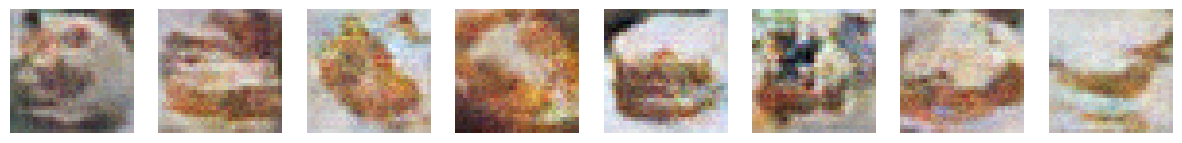

2024-11-10 20:33:13 — Epoch [2800/3000] — Discriminator Loss: 0.1085
2024-11-10 20:33:13 — Epoch [2800/3000] — Generator Loss: 2.7048


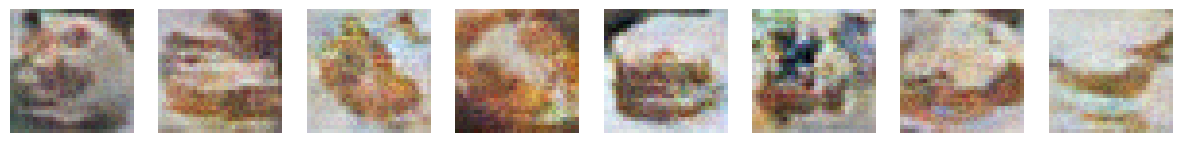

2024-11-10 20:36:17 — Epoch [2850/3000] — Discriminator Loss: 0.1085
2024-11-10 20:36:17 — Epoch [2850/3000] — Generator Loss: 2.7992


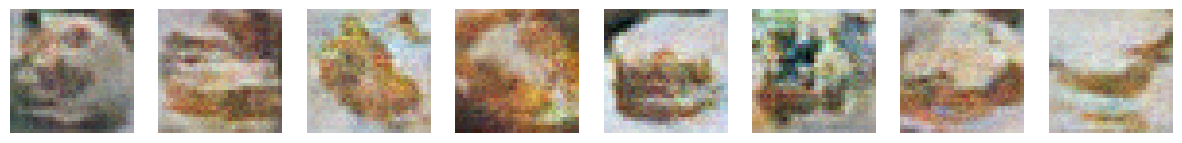

2024-11-10 20:39:22 — Epoch [2900/3000] — Discriminator Loss: 0.1083
2024-11-10 20:39:22 — Epoch [2900/3000] — Generator Loss: 2.7690


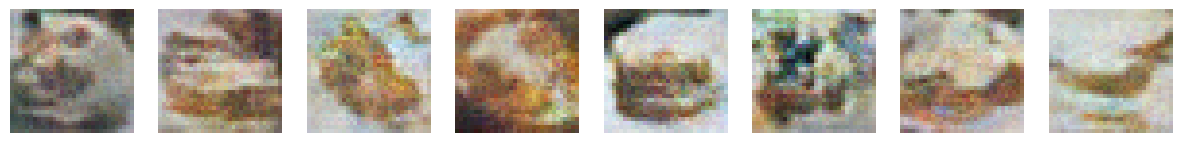

2024-11-10 20:42:26 — Epoch [2950/3000] — Discriminator Loss: 0.1015
2024-11-10 20:42:26 — Epoch [2950/3000] — Generator Loss: 2.7371


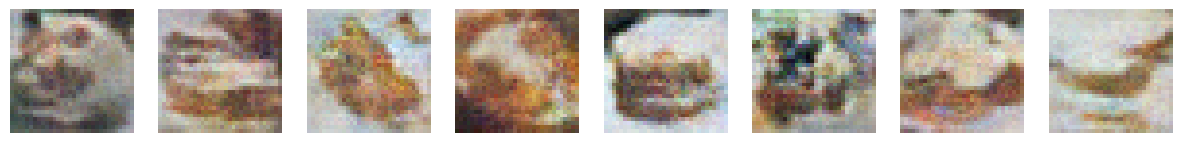

2024-11-10 20:45:30 — Epoch [3000/3000] — Discriminator Loss: 0.1020
2024-11-10 20:45:30 — Epoch [3000/3000] — Generator Loss: 2.7723


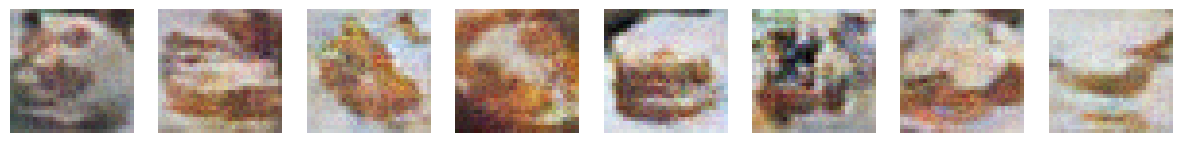

In [10]:
device: torch.device = torch.device(
    "mps" if torch.backends.mps.is_built()
        else "cuda" if torch.backends.cuda.is_built()
            else "cpu"
)

discriminator: Discriminator = Discriminator()
generator: Generator = Generator()

train(
    discriminator,
    generator,
    data_loader,
    device,
    epoch_count=3000,
    save_every_n_epochs=50
)

## No i co taki generator właściwie potrafi, he?

In [11]:
def reproduce_image(
    generator: Generator,
    target_image: torch.Tensor,
    step_count: int = 1000,
    generation_progress_frame_count: int = 8
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    noise: torch.Tensor = torch.randn(
        1, GENERATOR_INPUT_SIZE, requires_grad=True
    )
    initial_noise: torch.Tensor = noise.detach().clone()

    criterion = nn.MSELoss()
    optimizer = optim.SGD([noise], lr=0.01, momentum=0.9)

    save_progress_every: int \
        = step_count // (generation_progress_frame_count - 2)
    generated_image: torch.Tensor = torch.FloatTensor()
    generated_images: list[torch.Tensor] = []

    for step in range(step_count):
        generator.eval()
        generated_image = generator(noise)[0]

        if step % save_progress_every == 0 or step == step_count - 1:
            generated_images.append(generated_image)

        optimizer.zero_grad()

        loss = criterion(generated_image, target_image)
        loss.backward()

        optimizer.step()

    return (
        generated_image,
        noise,
        initial_noise,
        normalize_image(torch.stack(generated_images).detach().cpu()),
    )


def lets_reproduce_image(
    image_path: str,
    generator: Generator,
    change_noise=False,
    interpolate=False
) -> None:
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = transform(image)

    display(image.squeeze(dim=0) * 0.5 + 0.5, resize_scale=(8.0, 8.0))

    generated_image, noise, initial_noise, generated_images \
        = reproduce_image(generator, image)

    if interpolate:
        interpolated_noise_vectors = [
            torch.lerp(initial_noise, noise, t) for t in torch.linspace(0, 1, 8)
        ]
        generated_images = normalize_image(torch.stack([
            generator(noise)[0].detach().cpu()
            for noise in interpolated_noise_vectors
        ]))

    show_samples(generated_images)

    if change_noise:
        noise = noise.detach()
        noise[0][0] = 1.5
        noise[0][1] = 2.5
        noise[0][5] = 0.0
        noise[0][8] = -1.1

        generated_image = generator(noise)[0]

        display(generated_image, resize_scale=(8.0, 8.0))

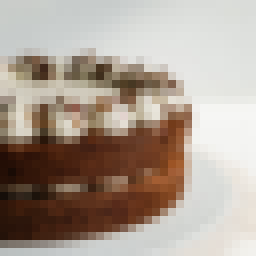

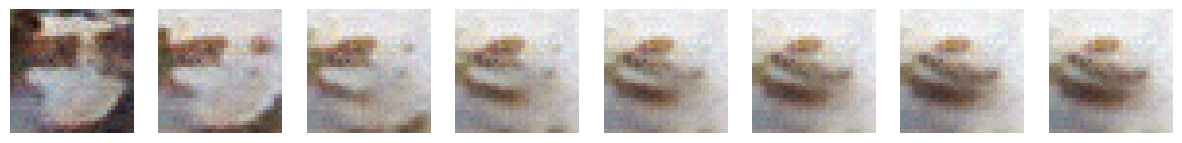

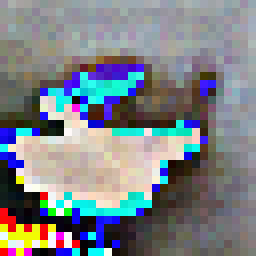

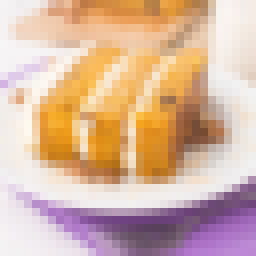

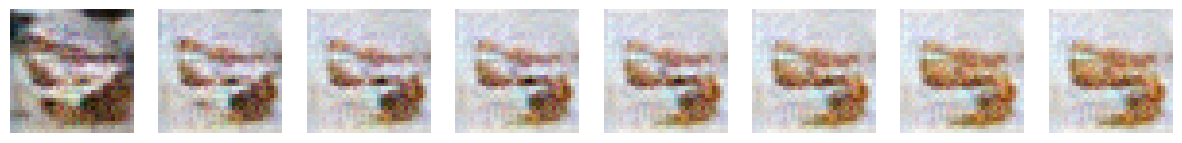

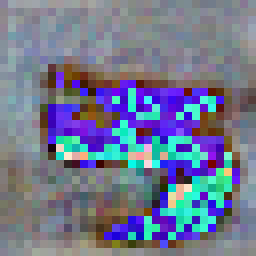

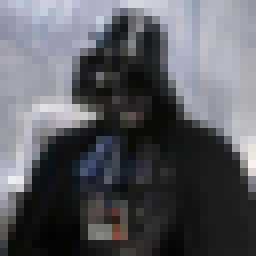

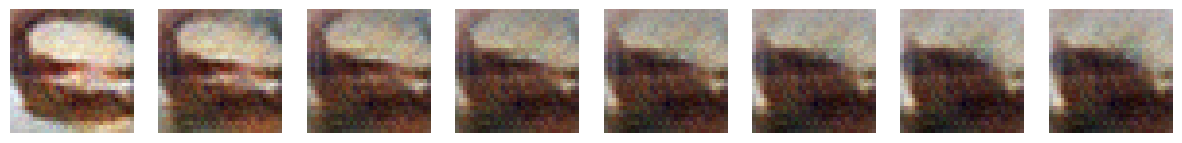

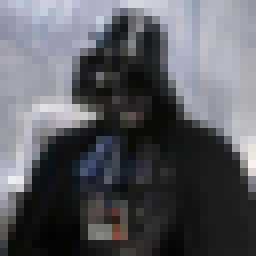

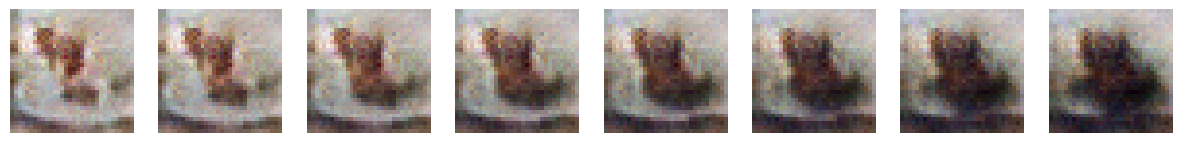

In [12]:
checkpoint = torch.load("checkpoints/torch/epoch_3000.pt", weights_only=True)
generator: Generator = Generator()
generator.load_state_dict(checkpoint["generator_state_dict"])

lets_reproduce_image(
    "dataset/crawled-cakes/156_7fba2edd.jpg", generator, change_noise=True
)
lets_reproduce_image(
    "dataset/crawled-cakes/053_2634e440.jpg", generator, change_noise=True
)
lets_reproduce_image(
    "dataset/star-wars/darth-vader.jpg", generator, interpolate=False
)
lets_reproduce_image(
    "dataset/star-wars/darth-vader.jpg", generator, interpolate=True
)